# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
4. [Optimizing Architecture](#Conditional-Generative-Adversarial-Network)
5. [Another perspective: Wasserstein Conditional Generative Adversarial Network](#Introducing-the-WGAN)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

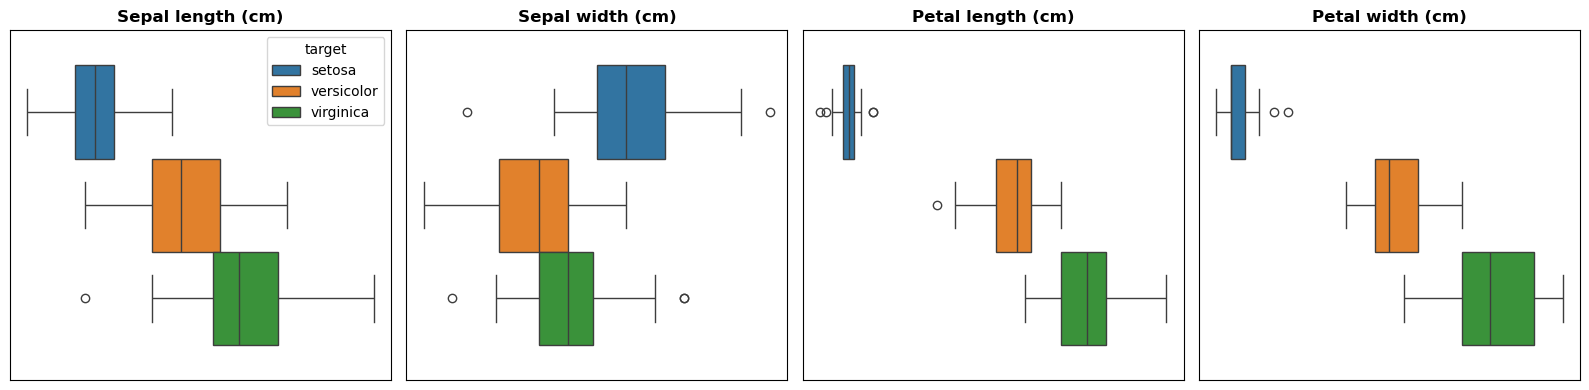

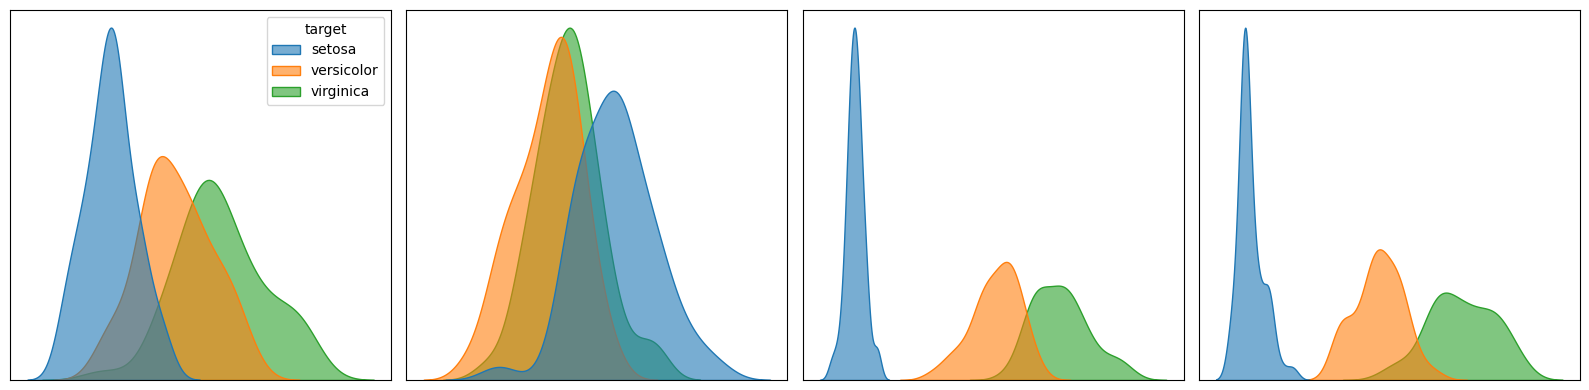

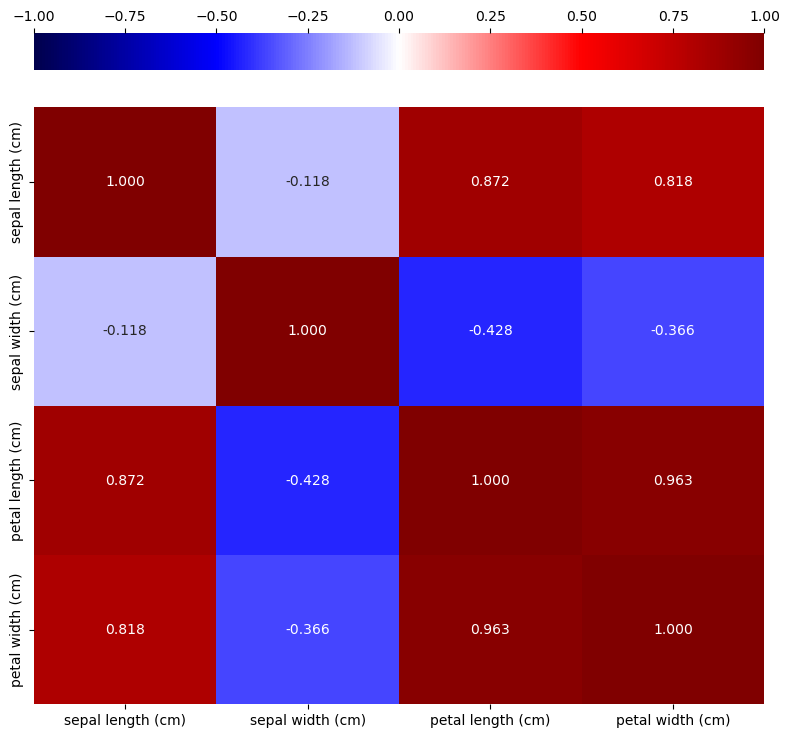

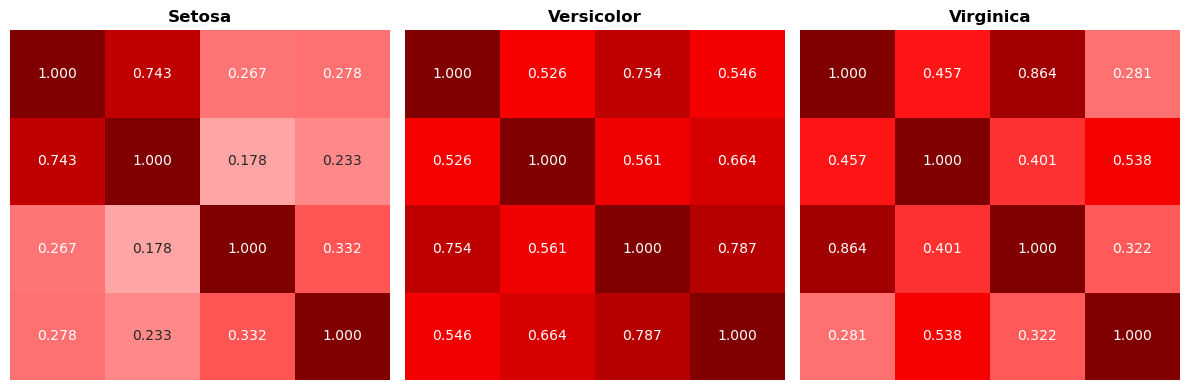

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.348305,3.175729,-0.896305,-0.724545,setosa
1,4.951439,2.708191,2.091509,1.755955,setosa
2,7.970627,3.344462,0.961085,0.081708,setosa
3,5.819503,4.897817,0.678211,0.661736,setosa
4,3.945850,2.407750,2.497726,-1.284515,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df).style.background_gradient('Reds', axis = 1)

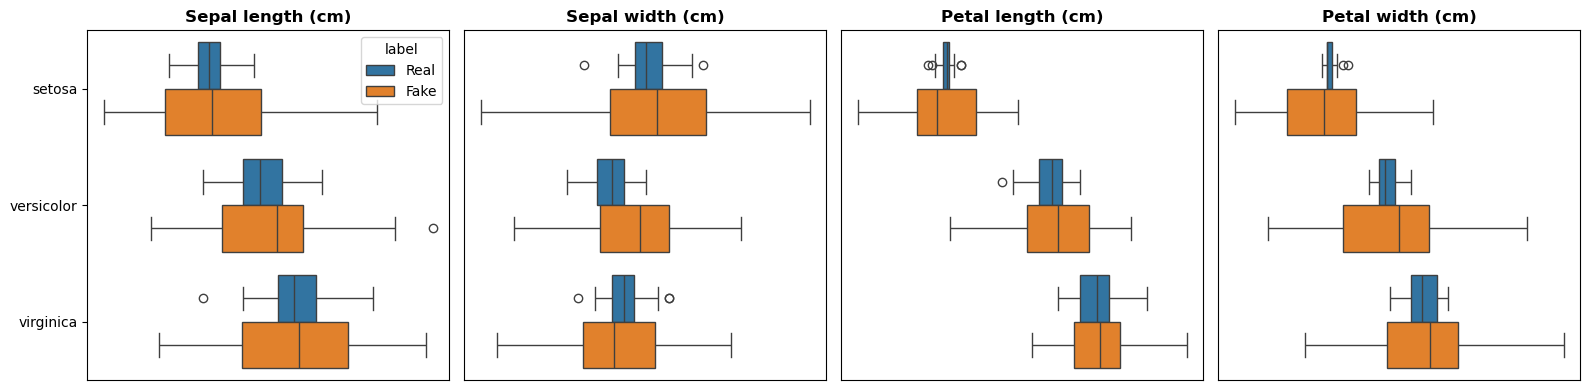

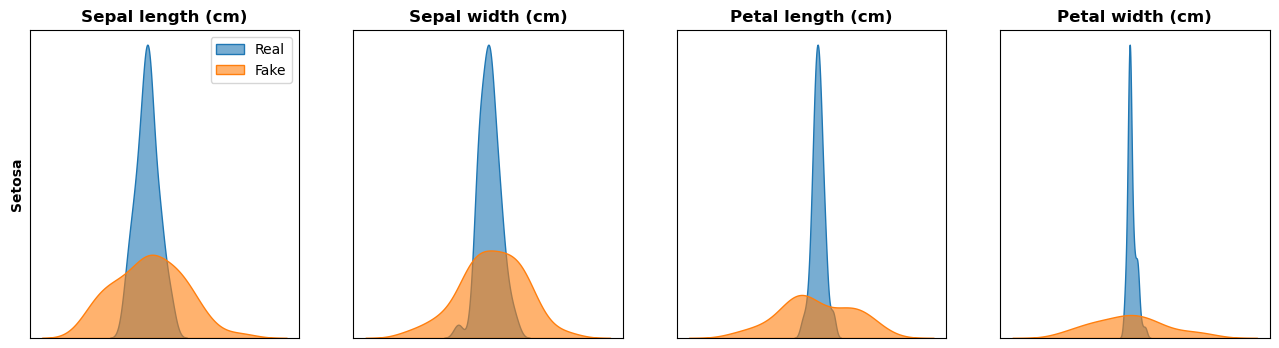

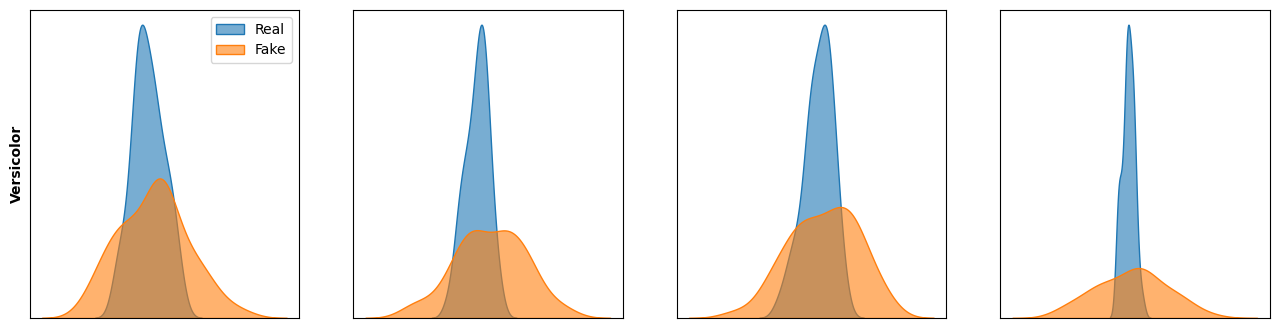

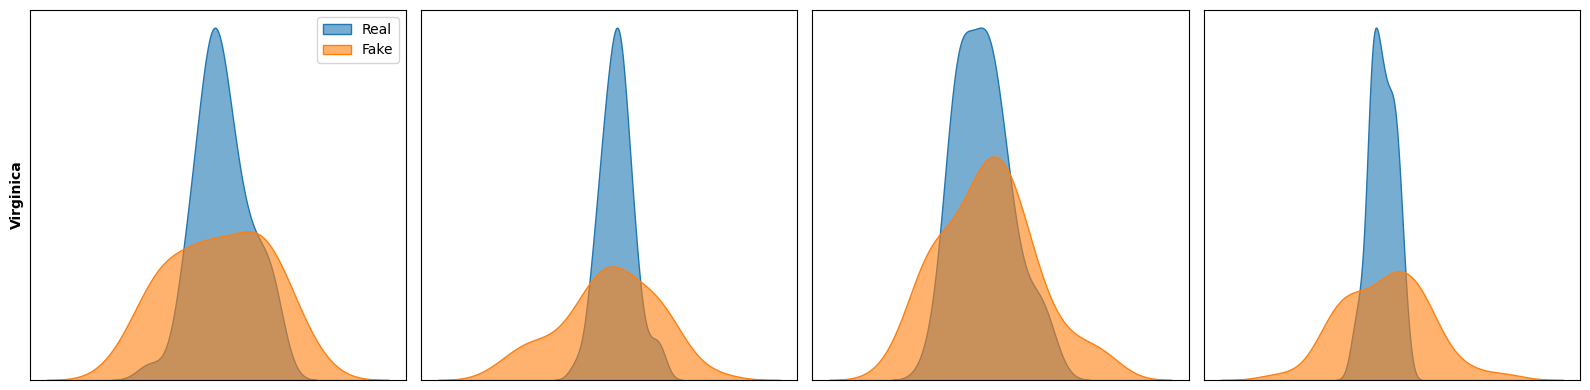

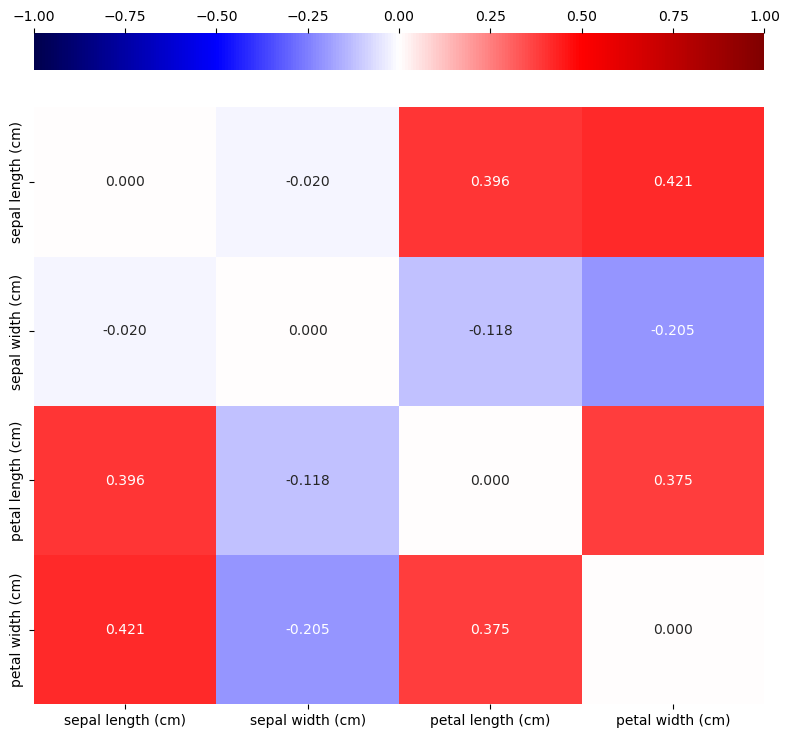

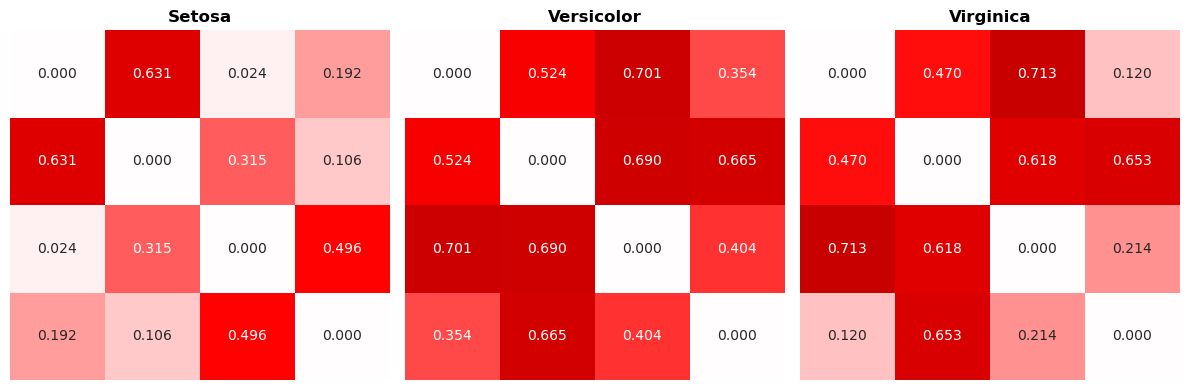

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader.

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE.

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
set_seed()
vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GAN's nets.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 810 parameters


Models have approximately the same number of parameters.

We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()
z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 100 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3227
MEAN: [-0.017  0.008 -0.08  -0.051]
STD:  [0.283 0.434 0.225 0.253]
MIN:  [-0.897 -1.855 -0.581 -0.465]
MAX:  [1.615 2.23  0.845 0.815]
SKEW: [ 0.647 -0.348  0.128  0.281]
KURT: [0.931 1.651 0.12  0.177]

Epoch 100/500 | Loss: 0.2992
MEAN: [-0.002  0.003 -0.072 -0.032]
STD:  [0.233 0.374 0.194 0.207]
MIN:  [-0.886 -1.741 -0.572 -0.453]
MAX:  [1.535 2.182 0.8   0.733]
SKEW: [ 0.473 -0.185  0.048  0.104]
KURT: [0.938 1.675 0.115 0.176]

Epoch 200/500 | Loss: 0.2913
MEAN: [-0.01  -0.001 -0.09  -0.051]
STD:  [0.224 0.368 0.182 0.19 ]
MIN:  [-0.877 -1.709 -0.568 -0.448]
MAX:  [1.538 2.174 0.797 0.722]
SKEW: [ 0.505 -0.103  0.089  0.129]
KURT: [0.929 1.672 0.111 0.171]

Epoch 300/500 | Loss: 0.2944
MEAN: [-0.013 -0.007 -0.089 -0.05 ]
STD:  [0.219 0.364 0.179 0.185]
MIN:  [-0.877 -1.717 -0.568 -0.448]
MAX:  [1.541 2.193 0.793 0.718]
SKEW: [ 0.499 -0.089  0.064  0.1  ]
KURT: [0.928 1.676 0.107 0.168]

Epoch 400/500 | Loss: 0.2872
MEAN: [-0.005 -0.006 -0.088 -0.052]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

Let's train the Conditional GAN.

In [18]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [19]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 100 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 200/500 | DLoss: 0.7312 | GLoss 0.6434
MEAN: [ 0.032 -0.386 -0.037 -0.121]
STD:  [ 0.147  0.315  0.119 -0.063]
MIN:  [-0.763 -1.7   -0.207 -0.03 ]
MAX:  [ 1.062  1.716  0.37  -0.073]
SKEW: [-0.217  0.858 -0.129 -0.168]
KURT: [0.87  1.638 0.069 0.152]

Epoch 300/500 | DLoss: 0.6807 | GLoss 0.7064
MEAN: [ 0.41  -0.046 -0.049 -0.151]
STD:  [0.234 0.235 0.136 0.043]
MIN:  [-0.19  -1.107 -0.176 -0.094]
MAX:  [1.713 1.681 0.518 0.068]
SKEW: [ 0.584 -0.189  0.305  0.292]
KURT: [0.878 1.544 0.0

In [20]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

Let's check which of the two results better approximates the actual data using the Kolmogorov-Smirnov test and the Wasserstein Distance.

In [21]:
print(f"KS test for VAE Data:\n{round(utils.calculate_ks_test(real_iris, vae_df), 5)}\n")
print(f"KS test for GAN Data:\n{round(utils.calculate_ks_test(real_iris, gan_df), 5)}\n")

print(f"WD for VAE Data:\n{round(utils.calculate_wasserstein_distance(real_iris, vae_df), 5)}\n")
print(f"WD for GAN Data:\n{round(utils.calculate_wasserstein_distance(real_iris, gan_df), 5)}")

KS test for VAE Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.21333  0.00211
1   sepal width (cm)       0.28000  0.00001
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

KS test for GAN Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.28667  0.00001
1   sepal width (cm)       0.29333  0.00000
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

WD for VAE Data:
             Feature  W Distance
0  sepal length (cm)     0.25957
1   sepal width (cm)     0.15692
2  petal length (cm)     0.41564
3   petal width (cm)     0.17683

WD for GAN Data:
             Feature  W Distance
0  sepal length (cm)     0.29182
1   sepal width (cm)     0.15968
2  petal length (cm)     0.63601
3   petal width (cm)     0.20348


As much as all the distances found using the KS test are significant (we have to reject H0 and so the distributions are not from the same population) these appear to be smaller overall for the VAE data. Even when examining Wasserstein's distances, the VAE seems to track the original distributions better. Let's check the Q-Q plots.

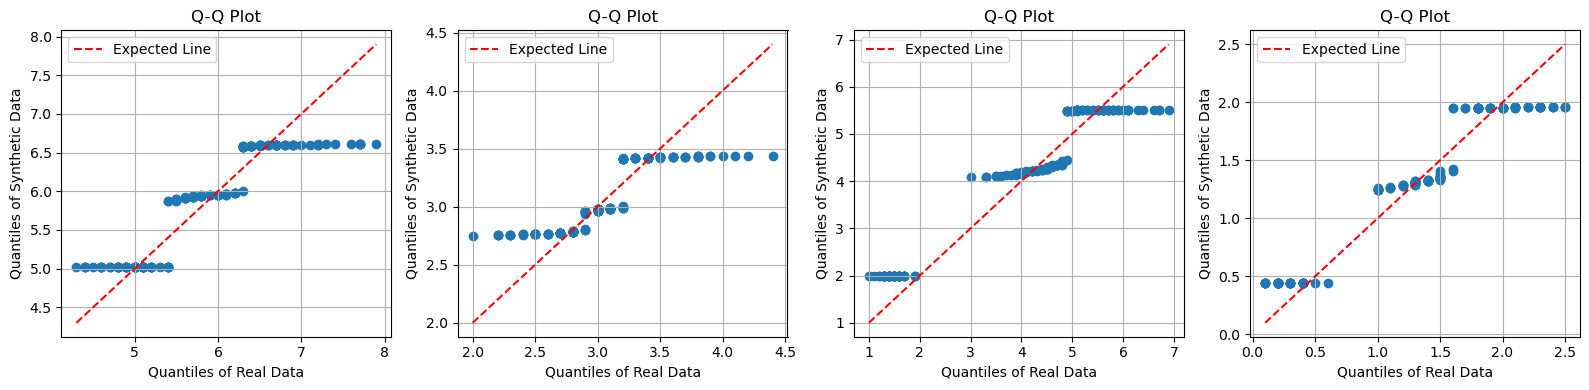

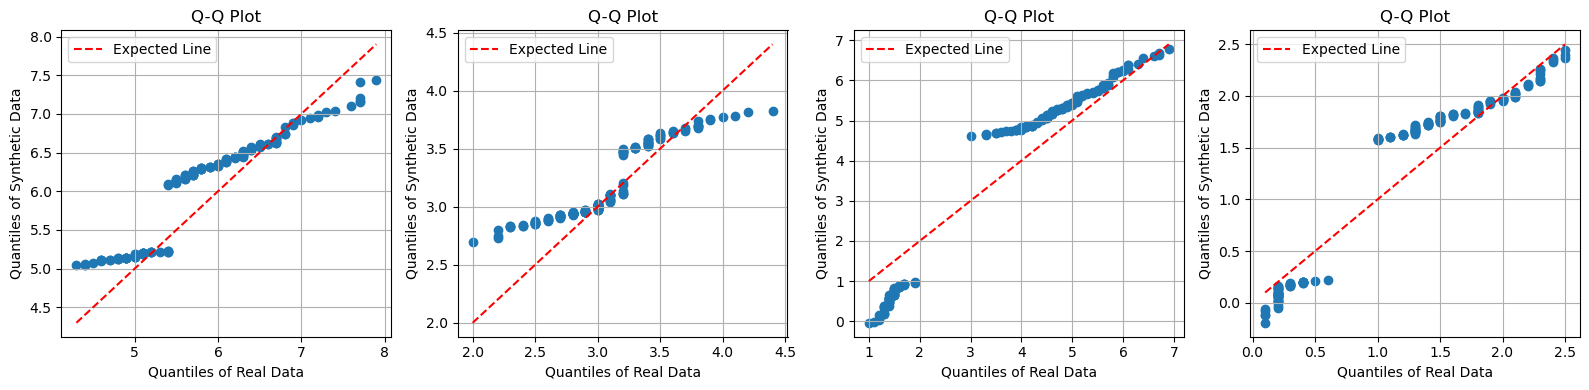

In [23]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

Examining the Q-Q plots there is slightly more overlap for the GAN-generated data. We will examine the data visually to make the final decision.

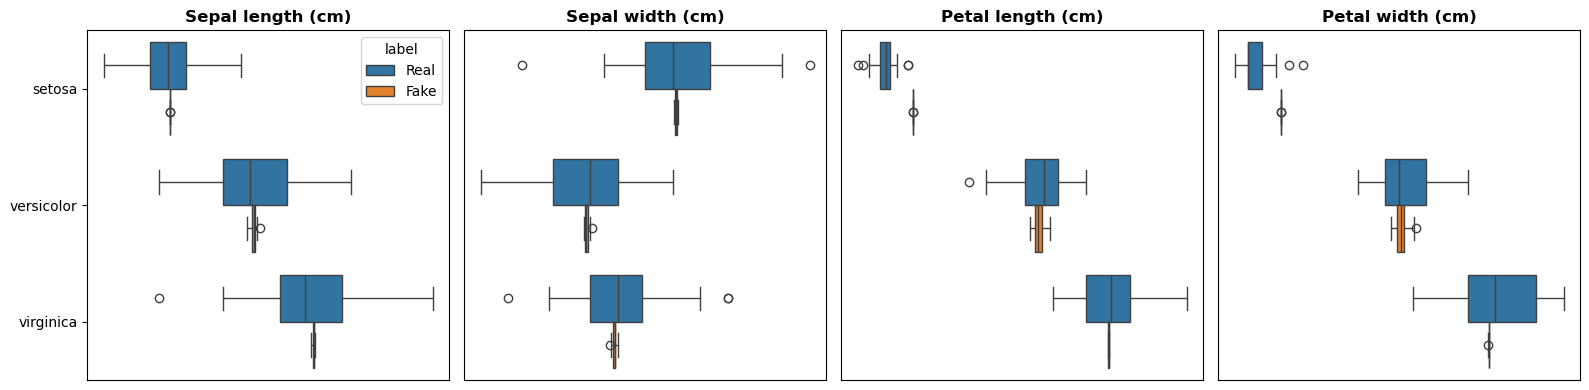

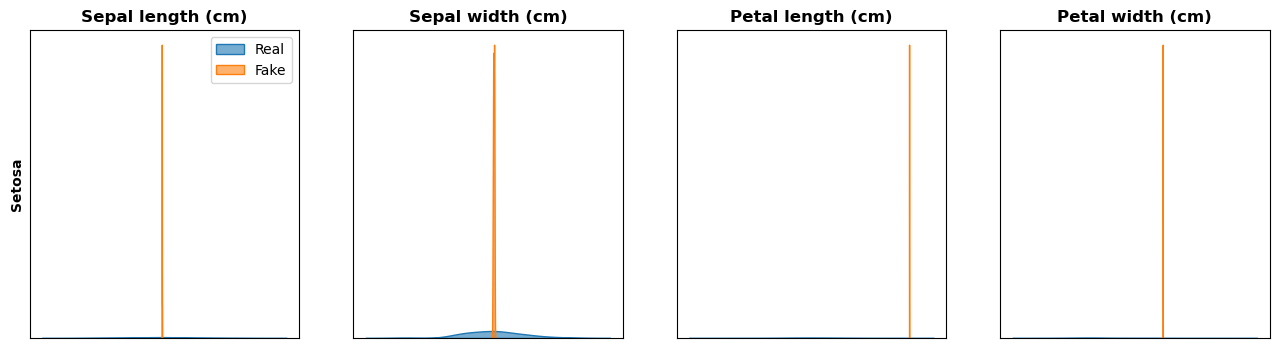

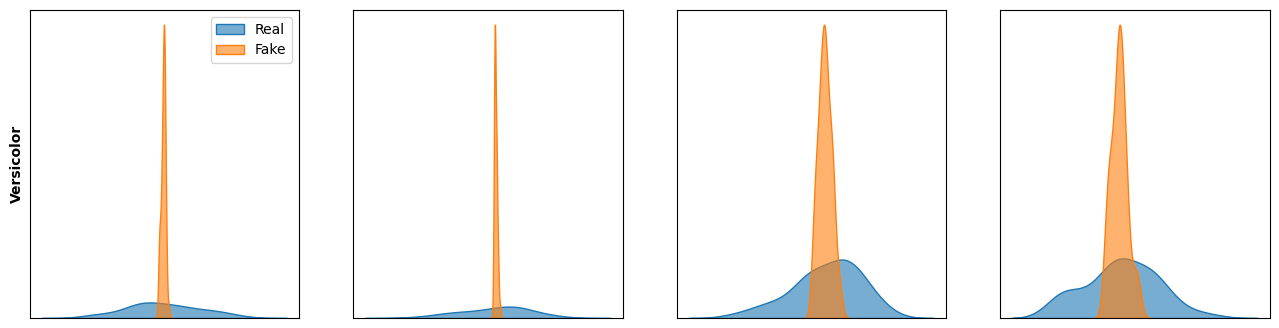

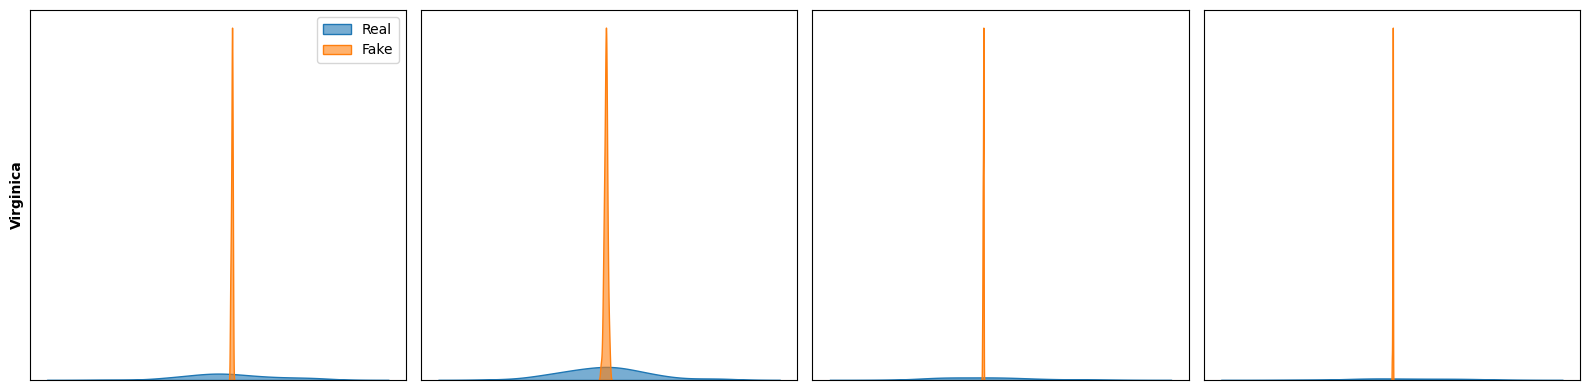

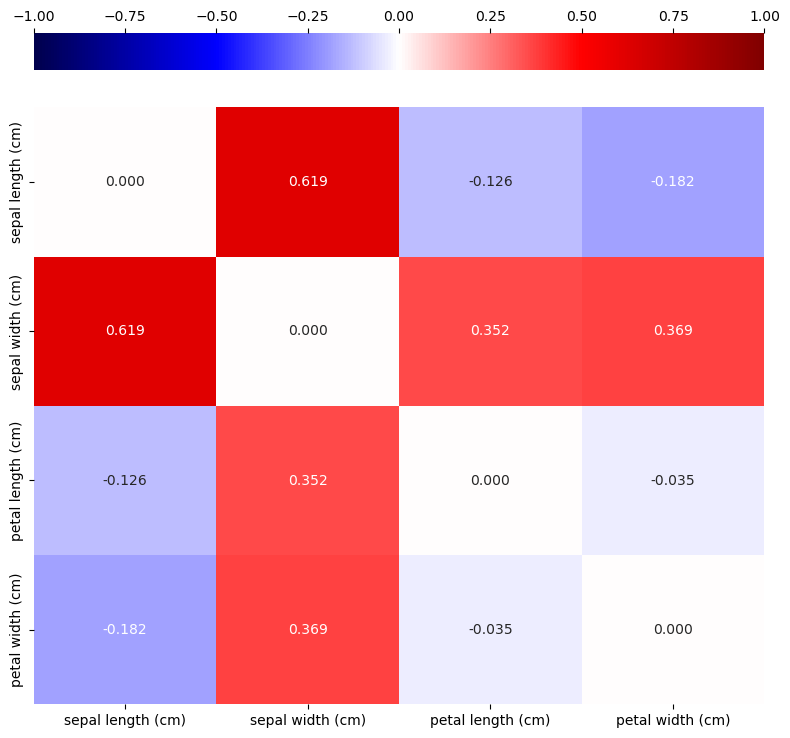

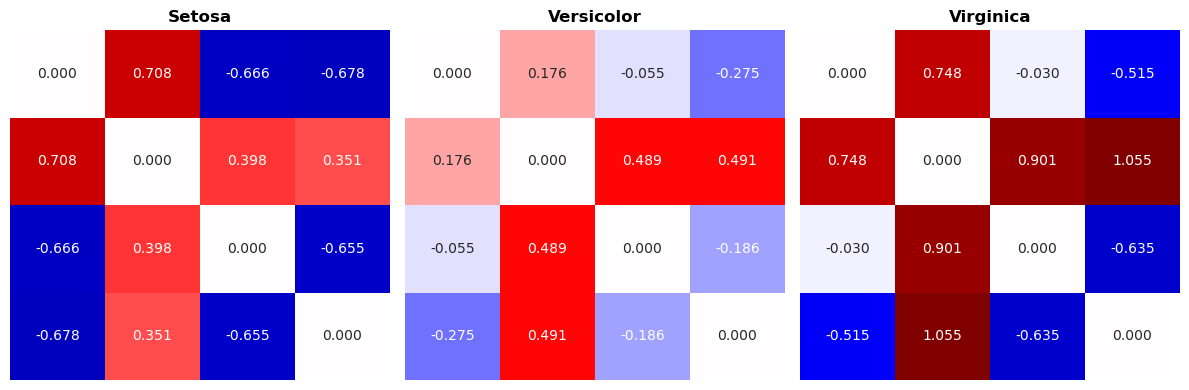

In [24]:
utils.plot_data(real_iris, 'target', vae_df)

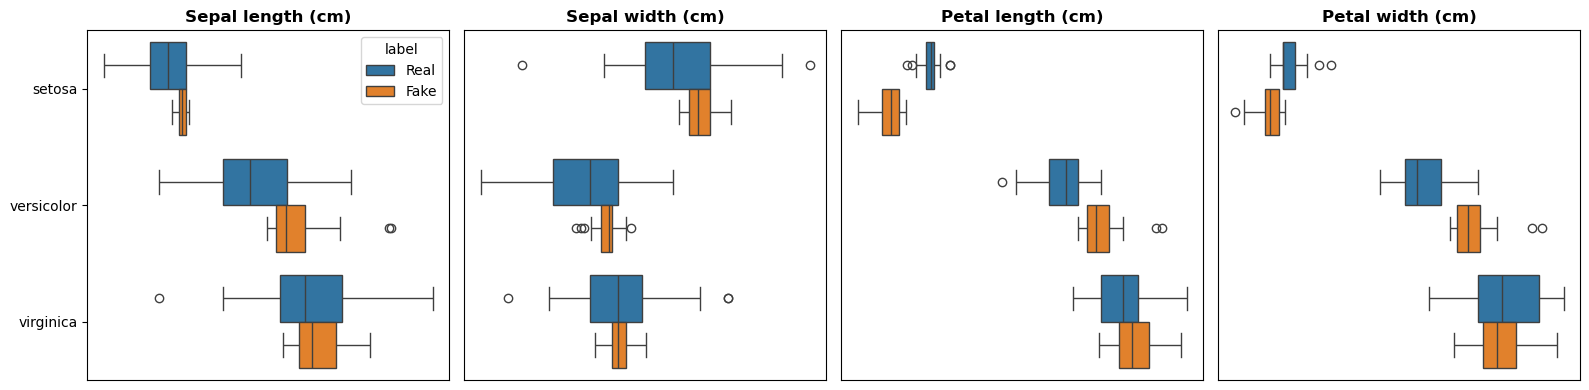

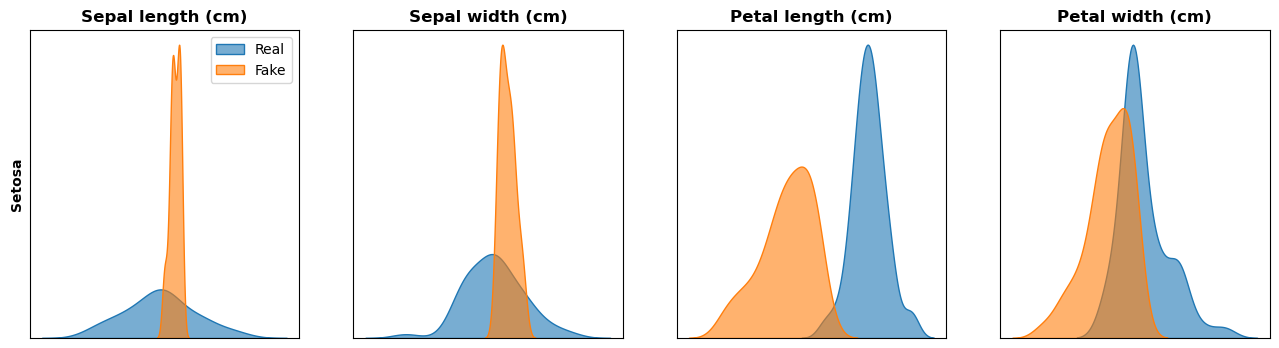

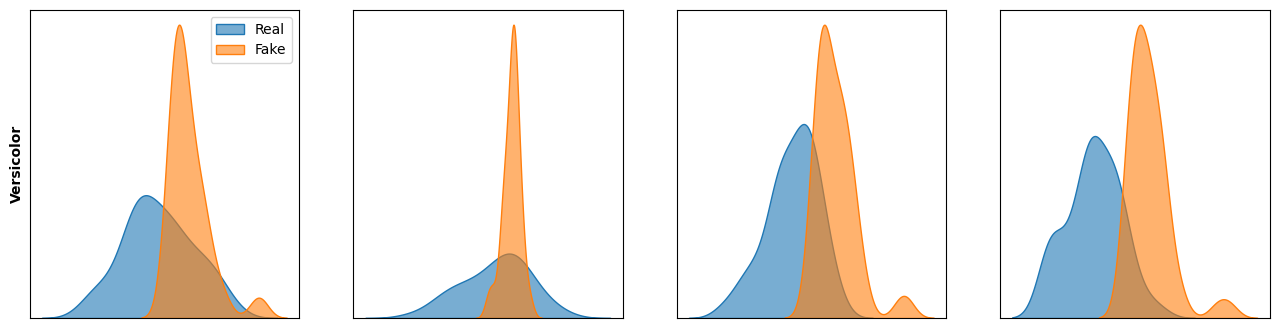

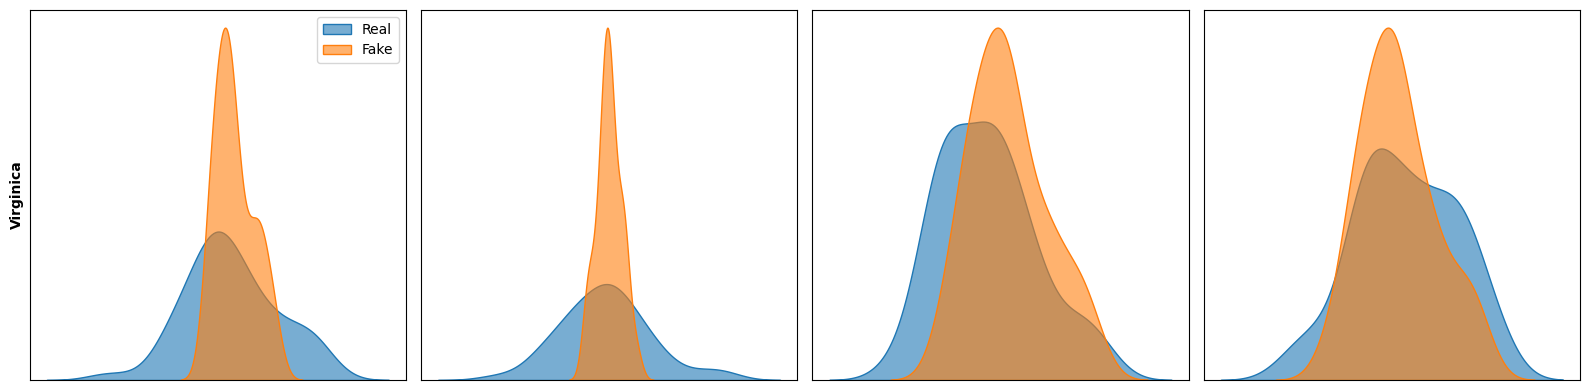

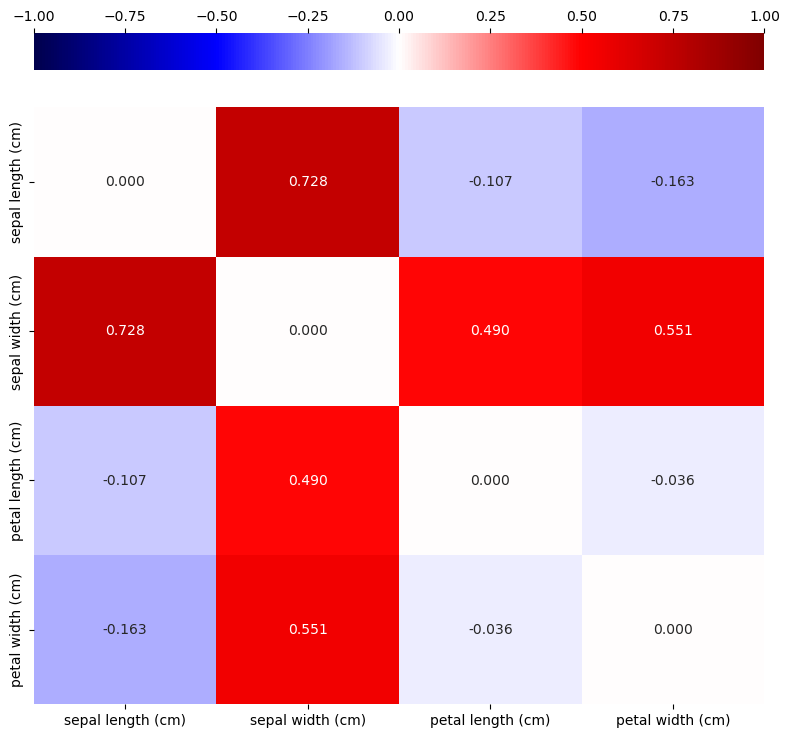

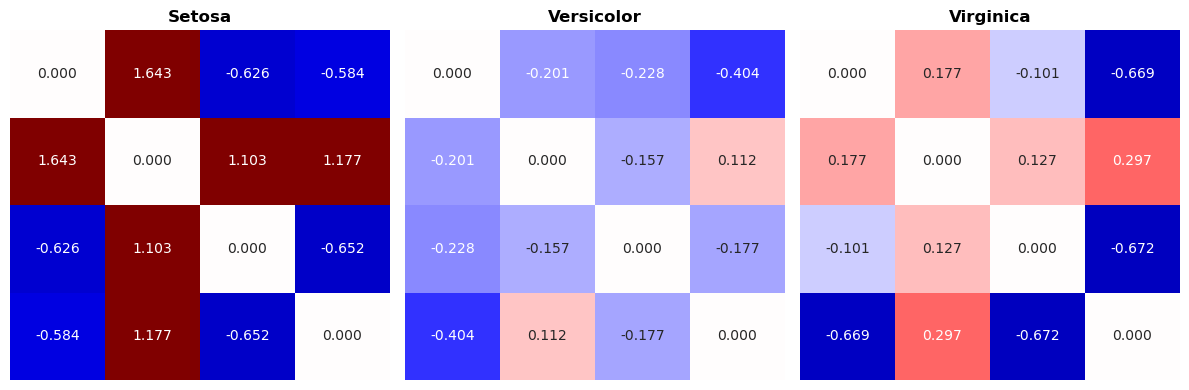

In [25]:
utils.plot_data(real_iris, 'target', gan_df)

As much as it can still be improved GAN seems to be the most suitable architecture for replicating data so the focus of the next steps will be on finding the best architecture.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best; grid search will also take place on the optimal size of the noise vector for which we will explore the following sizes: 2, 4, 8, 16, 32, and 64.

In [27]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

In [28]:
small_gan_dict = {'Generator': Generator1, 'Discriminator': Discriminator1, 
                  'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
med_gan_dict = {'Generator': Generator2, 'Discriminator': Discriminator2, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
big_gan_dict = {'Generator': Generator3, 'Discriminator': Discriminator3, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}

noise_size = [2**n for n in range(1, 7)]

criterion = nn.BCELoss()


for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for size_idx, size in enumerate(noise_size):
        
        set_seed()
        gen = model['Generator'](input_dim = size, num_classes = 3)
        disc = model['Discriminator'](input_dim = 4, num_classes = 3)
        
        g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
        d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)
        
        model['Noise Vector List'].append(size)
        model['Model Size'].append(sum(p.numel() for p in gen.parameters()))
        
        set_seed()
        z = torch.randn(150, size)
        
        for epoch in tqdm(range(501), desc = f'GAN {model_idx + 1} NV {size}'):
            
            gen_epoch_loss = 0
            disc_epoch_loss = 0
    
            disc.train()
            gen.train()
            
            for data, labels in real_gan_dataloader:
                
                real_data = data
                real_labels = torch.ones(real_data.shape[0], 1)
            
                train_z = torch.randn(real_data.shape[0], size)
                fake_data = gen(train_z, labels)
                fake_labels = torch.zeros(real_data.shape[0], 1)
            
                disc.zero_grad()
                
                real_loss = criterion(disc(real_data, labels), real_labels)
                fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
                d_loss = (real_loss + fake_loss) / 2
                disc_epoch_loss += d_loss.item()
                d_loss.backward()
            
                d_opt.step()
            
                gen.zero_grad()
            
                gen_labels = torch.ones(real_data.shape[0], 1)
            
                g_loss = criterion(disc(fake_data, labels), gen_labels)
                gen_epoch_loss += g_loss.item()
                g_loss.backward()
            
                g_opt.step()
                
            g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
            d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
            
            if epoch == 500:
        
                print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
                with torch.no_grad():
                    gen.eval()
                    gen_z = gen(z, real_gan_dataloader.dataset.label)
                    utils.compare_results(real_gan_dataloader.dataset.data, gen_z)
                    
        model['Dataframes'].append(std_scl.inverse_transform(gen(z, real_gan_dataloader.dataset.label).detach().numpy()))

GAN 1 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6209 | GLoss 0.9150
MEAN: [ 0.111 -0.704 -0.03  -0.01 ]
STD:  [ 0.018 -0.068  0.016 -0.189]
MIN:  [ 0.275 -1.34  -0.094  0.29 ]
MAX:  [ 0.722 -0.468  0.336  0.008]
SKEW: [ 0.514 -0.068  0.262  0.4  ]
KURT: [0.745 0.862 0.054 0.121]


GAN 1 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6592 | GLoss 0.7652
MEAN: [-0.262 -0.268 -0.035 -0.094]
STD:  [ 0.17   0.269 -0.321 -0.124]
MIN:  [-0.901 -1.602  0.591  0.386]
MAX:  [0.554 1.324 0.069 0.074]
SKEW: [ 0.578 -0.32   0.329  0.476]
KURT: [0.709 1.381 0.048 0.094]


GAN 1 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6970 | GLoss 0.6959
MEAN: [-0.584  0.194  0.21   0.155]
STD:  [ 0.458  0.105 -0.168  0.045]
MIN:  [-1.57  -0.66   0.42   0.156]
MAX:  [0.233 0.979 0.19  0.542]
SKEW: [-0.078 -0.019 -0.031  0.124]
KURT: [-0.119  0.795  0.048  0.123]


GAN 1 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.7018 | GLoss 0.6735
MEAN: [0.032 0.235 0.099 0.005]
STD:  [-0.01   0.029  0.032  0.193]
MIN:  [ 0.139  0.199  0.136 -0.17 ]
MAX:  [0.51  1.649 0.494 0.475]
SKEW: [ 0.25   0.336 -0.006 -0.041]
KURT: [0.725 1.051 0.078 0.14 ]


GAN 1 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6634 | GLoss 0.8109
MEAN: [-0.332  0.344  0.054  0.304]
STD:  [ 0.115  0.017  0.022 -0.102]
MIN:  [-0.431  0.8   -0.04   0.638]
MAX:  [ 0.18   0.997  0.316 -0.313]
SKEW: [ 0.345  0.222  0.208 -0.257]
KURT: [ 0.379  0.089  0.066 -0.055]


GAN 1 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6974 | GLoss 0.6930
MEAN: [-0.203 -0.059 -0.021  0.121]
STD:  [ 0.241  0.196 -0.015  0.054]
MIN:  [-0.873 -0.904 -0.108  0.262]
MAX:  [1.079 0.884 0.44  0.465]
SKEW: [ 0.535 -0.048  0.182  0.077]
KURT: [0.819 0.71  0.094 0.099]


GAN 2 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6829 | GLoss 0.7761
MEAN: [-0.799 -0.774 -0.459 -0.205]
STD:  [ 0.003  0.33  -0.304 -0.133]
MIN:  [-1.373 -1.53  -0.193  0.045]
MAX:  [-0.041  1.213 -0.599 -0.013]
SKEW: [-0.016  0.653 -0.104  0.213]
KURT: [0.915 1.005 0.083 0.134]


GAN 2 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6963 | GLoss 0.7200
MEAN: [ 0.004  0.128 -0.187 -0.025]
STD:  [-0.07   0.246  0.041 -0.014]
MIN:  [ 0.079 -1.131 -0.382  0.091]
MAX:  [-0.321  0.577 -0.193  0.04 ]
SKEW: [ 0.074 -0.799 -0.054  0.108]
KURT: [ 0.116 -1.072  0.017  0.087]


GAN 2 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5497 | GLoss 0.8513
MEAN: [-0.273 -0.618 -0.073 -0.067]
STD:  [0.149 0.451 0.089 0.059]
MIN:  [-0.425 -2.081 -0.128  0.083]
MAX:  [0.357 1.299 0.349 0.104]
SKEW: [0.139 0.397 0.011 0.03 ]
KURT: [0.496 0.93  0.088 0.129]


GAN 2 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6488 | GLoss 0.7494
MEAN: [0.002 0.123 0.148 0.003]
STD:  [0.107 0.13  0.109 0.089]
MIN:  [-0.327 -0.569  0.128 -0.089]
MAX:  [0.663 0.792 0.869 0.337]
SKEW: [0.357 0.006 0.218 0.277]
KURT: [0.657 0.422 0.08  0.132]


GAN 2 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6152 | GLoss 0.8094
MEAN: [-0.181  0.032 -0.049  0.13 ]
STD:  [ 0.065  0.028 -0.049  0.118]
MIN:  [-0.301 -0.588 -0.01   0.202]
MAX:  [0.572 0.707 0.469 0.508]
SKEW: [ 0.315 -0.335  0.241  0.233]
KURT: [ 0.614  0.137  0.076 -0.014]


GAN 2 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6222 | GLoss 1.1875
MEAN: [ 0.119 -0.083 -0.029  0.122]
STD:  [0.123 0.135 0.047 0.133]
MIN:  [-0.414 -0.875 -0.143 -0.073]
MAX:  [0.948 1.65  0.294 0.525]
SKEW: [0.239 0.29  0.221 0.169]
KURT: [0.871 1.657 0.052 0.126]


GAN 3 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6680 | GLoss 0.8431
MEAN: [ 0.365 -0.109  0.119 -0.056]
STD:  [-0.015  0.632 -0.062 -0.182]
MIN:  [ 0.412 -1.525  0.548  0.515]
MAX:  [1.598 2.172 0.561 0.159]
SKEW: [0.928 0.502 0.347 0.287]
KURT: [0.841 0.57  0.021 0.137]


GAN 3 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5840 | GLoss 0.9956
MEAN: [ 0.014 -0.229 -0.007 -0.007]
STD:  [-0.114  0.569 -0.168 -0.275]
MIN:  [-0.239 -1.999  0.437  0.903]
MAX:  [-0.153  1.863 -0.626 -0.262]
SKEW: [ 0.122  0.078 -0.231 -0.144]
KURT: [ 0.759  1.358 -0.061  0.11 ]


GAN 3 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6487 | GLoss 0.8209
MEAN: [ 0.119 -0.883 -0.216 -0.55 ]
STD:  [ 0.094 -0.071 -0.001 -0.079]
MIN:  [-0.357 -1.515 -0.175 -0.22 ]
MAX:  [ 0.514 -1.678 -0.117 -0.557]
SKEW: [ 0.164 -0.541  0.054  0.292]
KURT: [ 0.328 -0.389 -0.001  0.109]


GAN 3 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6455 | GLoss 0.8099
MEAN: [0.126 0.074 0.045 0.052]
STD:  [ 0.141 -0.113  0.106  0.042]
MIN:  [-0.048  0.079 -0.078  0.054]
MAX:  [0.801 1.192 0.551 0.306]
SKEW: [0.158 0.554 0.287 0.31 ]
KURT: [0.411 0.945 0.007 0.06 ]


GAN 3 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6830 | GLoss 0.7960
MEAN: [-0.55  -0.739 -0.035 -0.233]
STD:  [-0.103  0.014  0.042 -0.257]
MIN:  [-0.462 -0.321 -0.232 -0.177]
MAX:  [ 0.241  1.118  0.344 -0.619]
SKEW: [ 0.498  1.313 -0.323 -0.339]
KURT: [0.903 0.077 0.14  0.135]


GAN 3 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6885 | GLoss 0.7017
MEAN: [-0.147 -0.534  0.047  0.055]
STD:  [ 0.269 -0.059 -0.016 -0.157]
MIN:  [-0.928 -0.433  0.038  0.426]
MAX:  [1.09  0.605 0.332 0.044]
SKEW: [ 0.329 -0.052  0.024  0.102]
KURT: [0.791 1.394 0.064 0.112]


Let's check models' size.

In [29]:
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Model Size']):
        print(f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]} -> {size/1000}k parameters")

GAN 1 NV 2 -> 0.797k parameters
GAN 1 NV 4 -> 0.861k parameters
GAN 1 NV 8 -> 0.989k parameters
GAN 1 NV 16 -> 1.245k parameters
GAN 1 NV 32 -> 1.757k parameters
GAN 1 NV 64 -> 2.781k parameters
GAN 2 NV 2 -> 3.069k parameters
GAN 2 NV 4 -> 3.197k parameters
GAN 2 NV 8 -> 3.453k parameters
GAN 2 NV 16 -> 3.965k parameters
GAN 2 NV 32 -> 4.989k parameters
GAN 2 NV 64 -> 7.037k parameters
GAN 3 NV 2 -> 11.709k parameters
GAN 3 NV 4 -> 11.965k parameters
GAN 3 NV 8 -> 12.477k parameters
GAN 3 NV 16 -> 13.501k parameters
GAN 3 NV 32 -> 15.549k parameters
GAN 3 NV 64 -> 19.645k parameters


As the size of the noise vector changes, the dimensions, in terms of parameters of each architecture remain quite similar.

In [30]:
ks_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        ks_results = utils.calculate_ks_test(real_iris, pd.DataFrame(size))
        ks_statistics = ks_results['KS Statistic']
        ks_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **ks_statistics})
comaprisons_df = pd.DataFrame(ks_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_ks'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_ks').style.background_gradient(cmap = 'Reds')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),avg_ks
Model,,,,,
GAN 3 NV 16,0.100000,0.133333,0.146667,0.180000,0.140000
GAN 2 NV 32,0.126667,0.146667,0.153333,0.166667,0.148333
GAN 1 NV 64,0.226667,0.113333,0.133333,0.140000,0.153333
GAN 2 NV 16,0.100000,0.153333,0.200000,0.200000,0.163333
GAN 2 NV 64,0.173333,0.173333,0.140000,0.180000,0.166667
GAN 2 NV 4,0.093333,0.160000,0.313333,0.133333,0.175000
GAN 1 NV 16,0.146667,0.206667,0.146667,0.266667,0.191667
GAN 1 NV 32,0.186667,0.206667,0.173333,0.280000,0.211667
GAN 3 NV 64,0.246667,0.233333,0.146667,0.266667,0.223333


In [31]:
wd_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        wd_results = utils.calculate_wasserstein_distance(real_iris, pd.DataFrame(size))
        wd_statistics = wd_results['W Distance']
        wd_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **wd_statistics})
comaprisons_df = pd.DataFrame(wd_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_wd'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_wd').style.background_gradient(cmap = 'Reds')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),avg_wd
Model,,,,,
GAN 2 NV 16,0.118965,0.069324,0.261644,0.105965,0.138974
GAN 2 NV 64,0.160924,0.132034,0.181203,0.123224,0.149347
GAN 2 NV 4,0.075668,0.126776,0.328192,0.077650,0.152072
GAN 3 NV 16,0.129224,0.093377,0.276227,0.118178,0.154252
GAN 2 NV 32,0.193202,0.057667,0.248208,0.130035,0.157278
GAN 1 NV 16,0.128923,0.110510,0.246658,0.159210,0.161325
GAN 1 NV 64,0.274651,0.074916,0.196574,0.102701,0.162210
GAN 3 NV 64,0.233453,0.238512,0.202242,0.139431,0.203409
GAN 1 NV 32,0.296999,0.149471,0.173592,0.238520,0.214645


The final match is between the best model considering the KS test, a big GAN with a noise vector of 16, and the best according to the wasserstein distance, a medium GAN with a noise vector of 16.
Considering that the performance of all three architectures with a vector of size 16 reaches an acceptable threshold, we can conclude that this is the optimal size of the noise vector.

By examining the Q-Q plots we will see which architecture produces the best results.

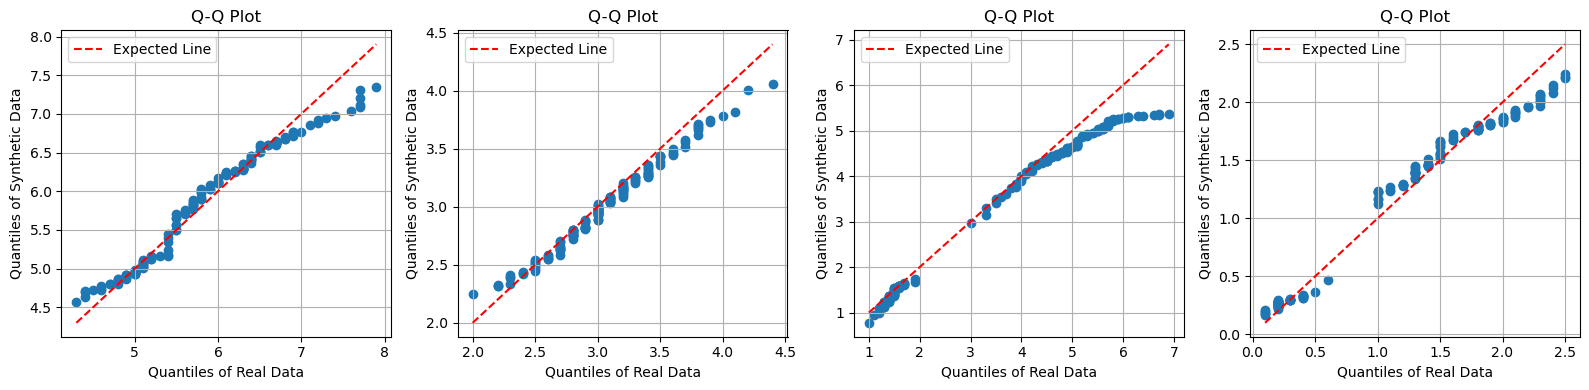

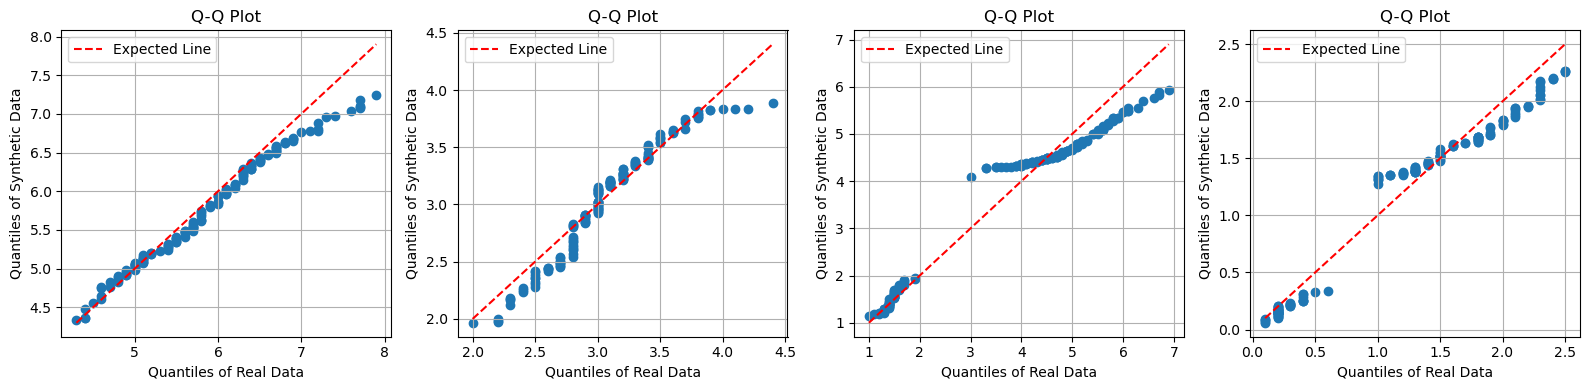

In [33]:
gan2_16nv_df = pd.DataFrame(med_gan_dict['Dataframes'][3])
gan2_16nv_df['target'] = y
gan2_16nv_df['target'] = gan2_16nv_df['target'].map({i: species[i] for i in range(len(species))})
gan2_16nv_df.columns = real_iris.columns

gan3_16nv_df = pd.DataFrame(big_gan_dict['Dataframes'][3])
gan3_16nv_df['target'] = y
gan3_16nv_df['target'] = gan3_16nv_df['target'].map({i: species[i] for i in range(len(species))})
gan3_16nv_df.columns = real_iris.columns

for dataframe in [gan2_16nv_df, gan3_16nv_df]:
    utils.plot_quantiles(real_iris, dataframe)

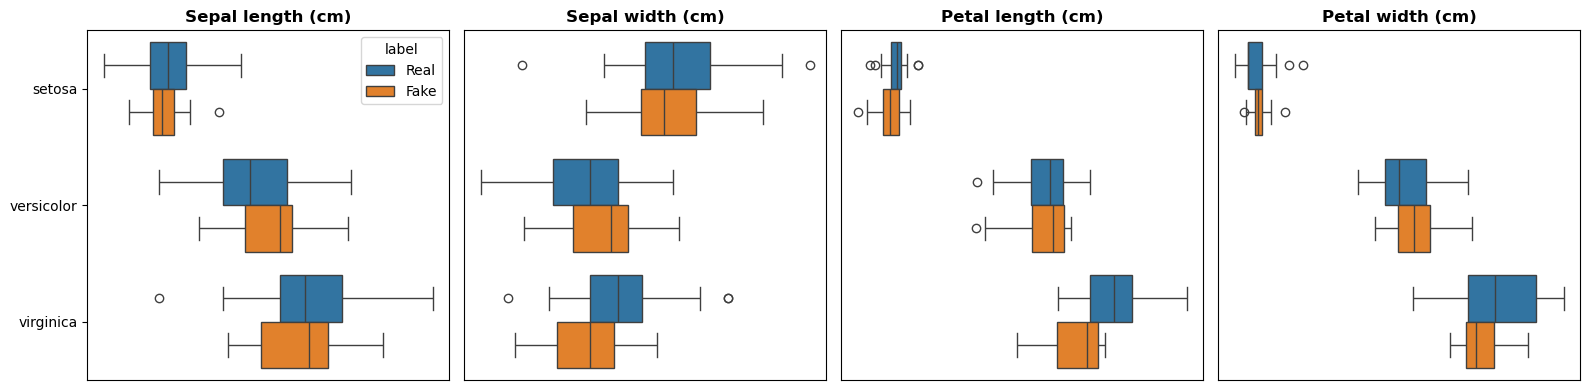

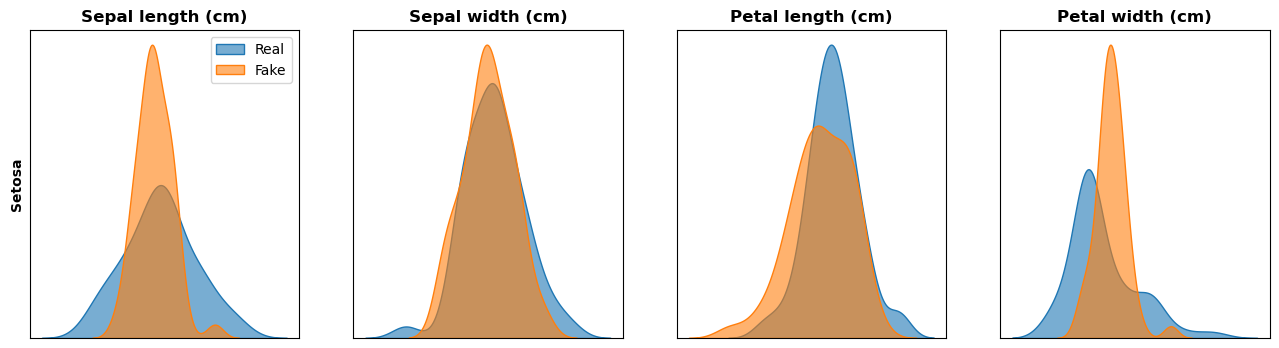

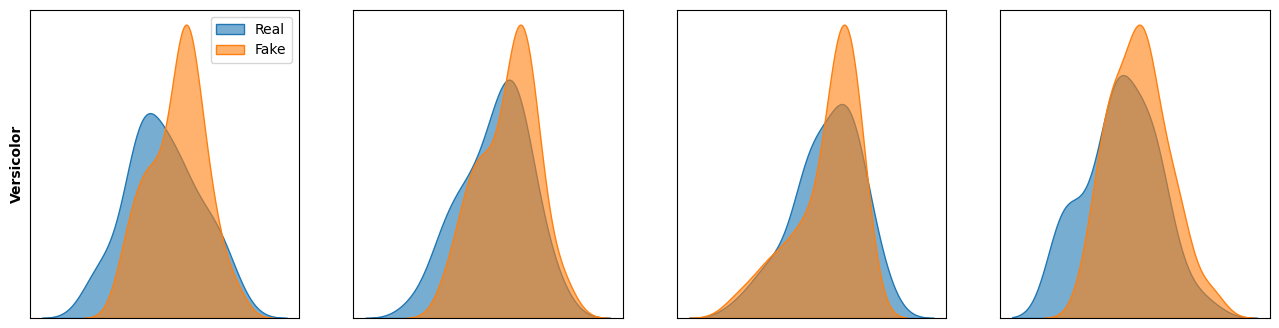

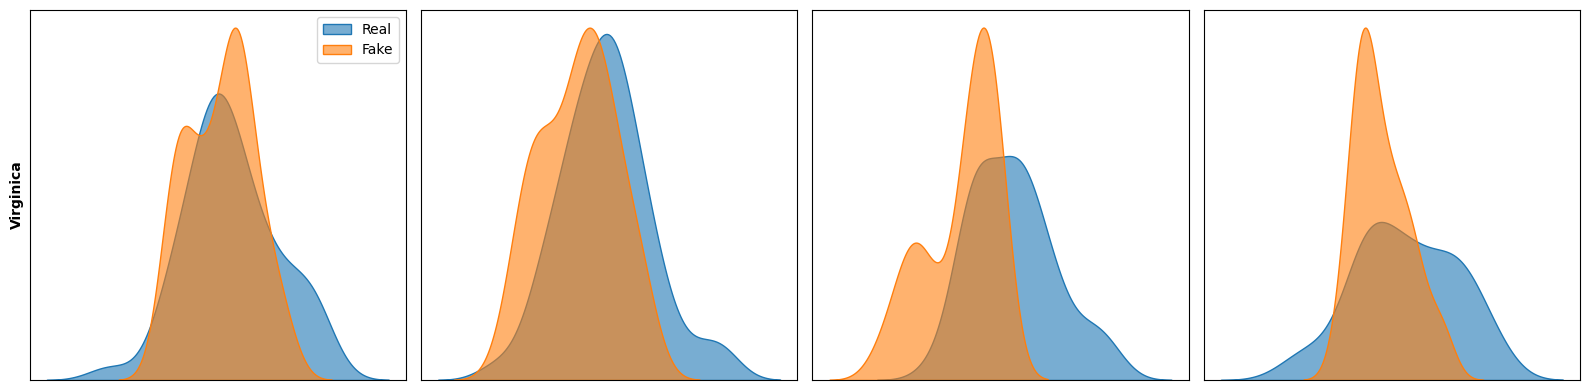

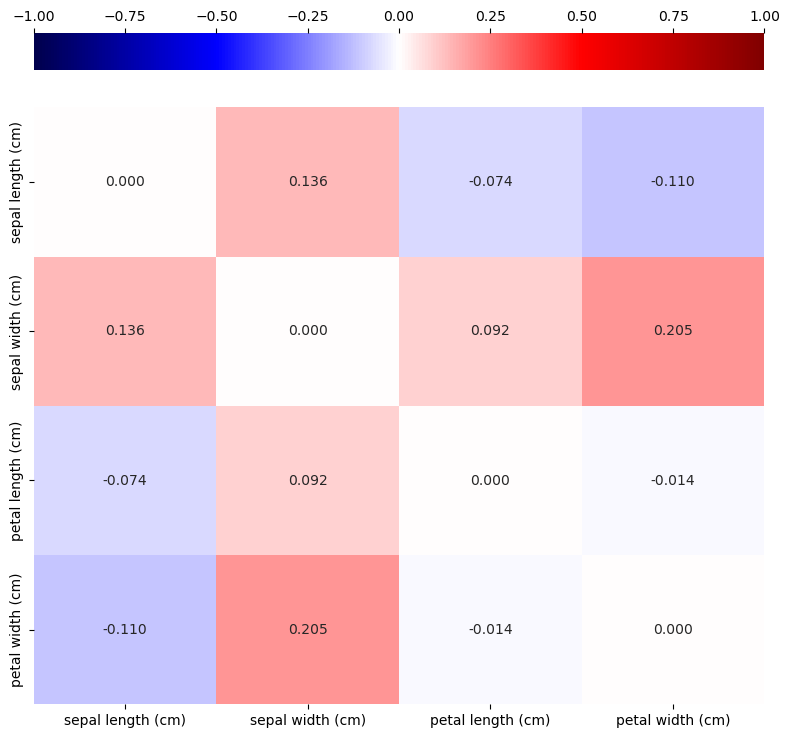

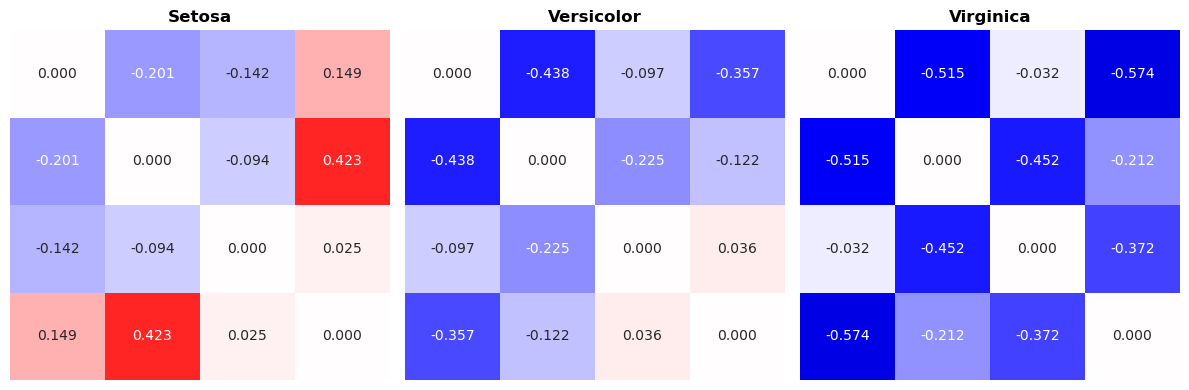

In [34]:
utils.plot_data(real_iris, 'target', gan2_16nv_df)

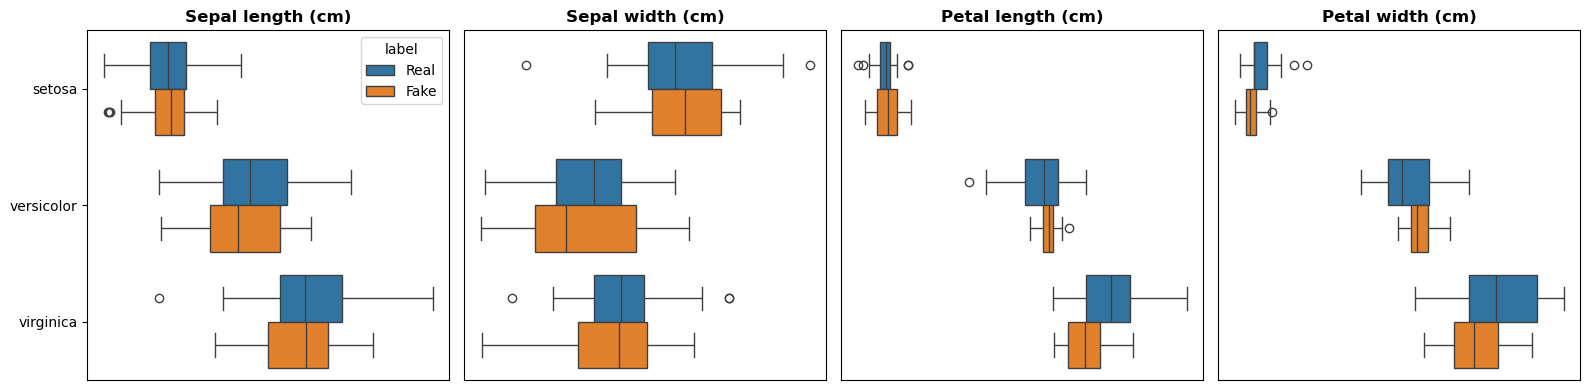

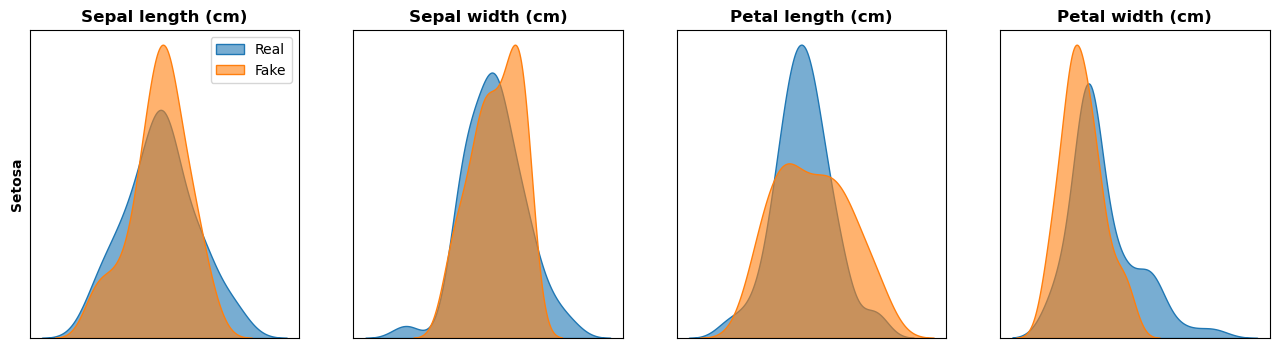

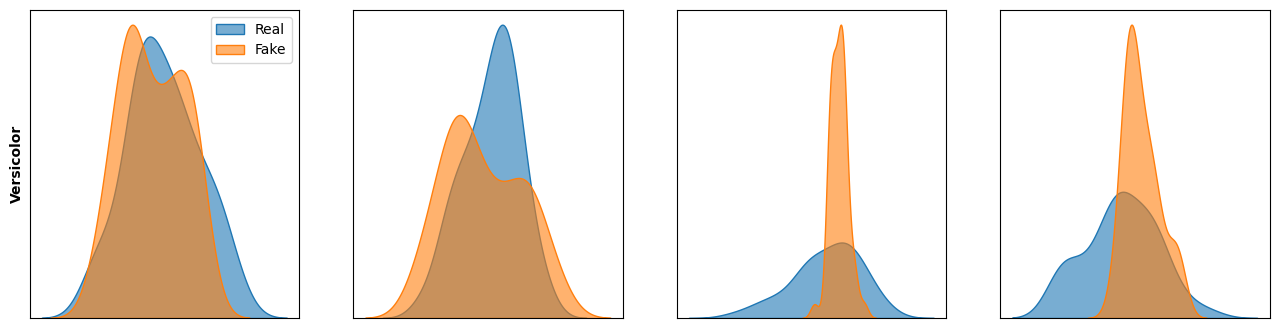

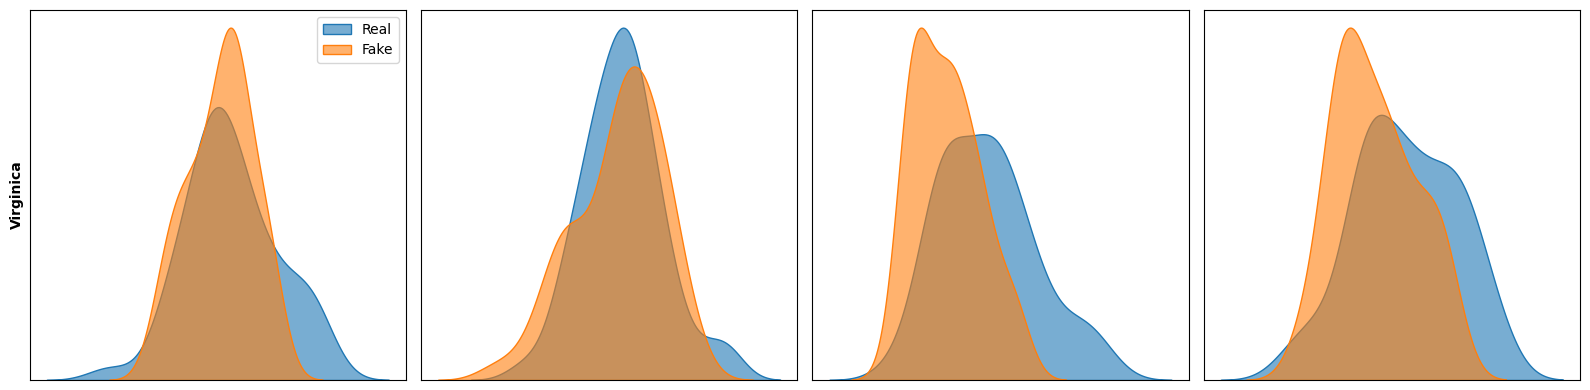

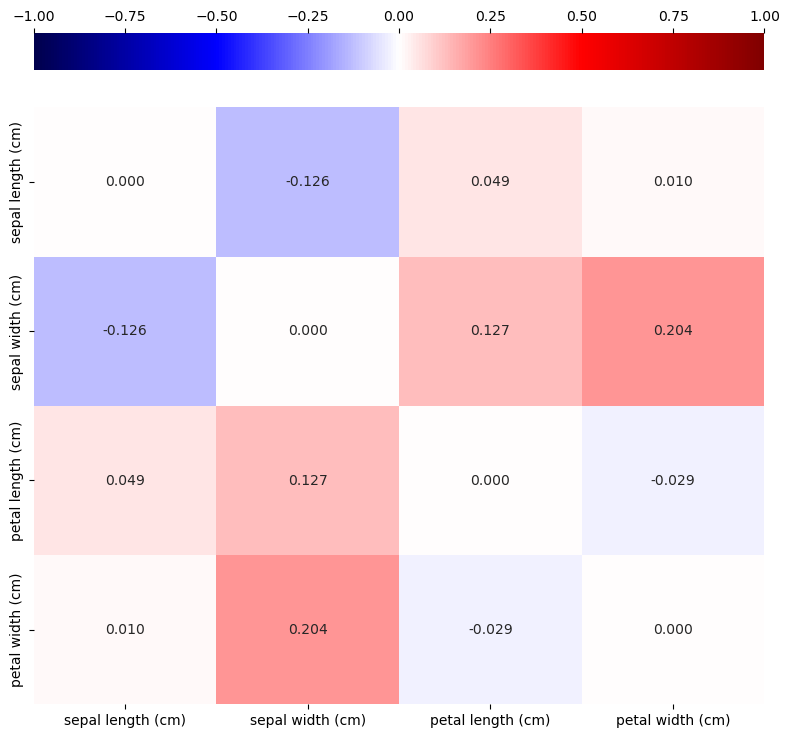

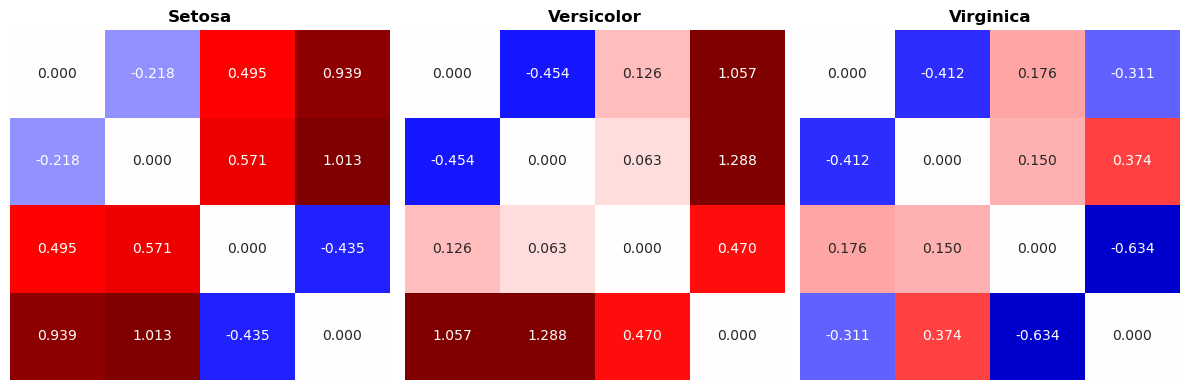

In [35]:
utils.plot_data(real_iris, 'target', gan3_16nv_df)

In [36]:
print(f"Medium GAN: {((real_iris.select_dtypes('number').corr() - gan2_16nv_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print(f"Big GAN: {((real_iris.select_dtypes('number').corr() - gan3_16nv_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Medium GAN: 1.2608
Big GAN: 1.0914


In [37]:
print('Medium GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - gan2_16nv_df[gan2_16nv_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print('\nBig GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - gan3_16nv_df[gan3_16nv_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Medium GAN correlation differences:

Setosa: 2.0704
Versicolor: 2.5484
Virginica: 4.3110

Big GAN correlation differences:

Setosa: 7.3449
Versicolor: 6.9146
Virginica: 4.1133


Analyzing the performance of both models with statistical and graphical methods, they seem to show rather similar performance overall. Analyzing the differences between the class-specific correlations, the average architecture shows a greater ability to reproduce 2 out of 3 classes. For this the **medium architecture with a noise vector of size 16** will be chosen.

## Introducing the WGAN